## Analysis 03: Comparing Sentiments of Famous People with their Followers

##### SETTING UP THE TWITTER API

In [1]:
import os
import tweepy as tw
import pandas as pd

consumer_key = 'qWaI6kizU7SAcRNc6EnnoNChq'
consumer_secret = 'xumE7NgIZMiLCUXFeEl0pr3zhsuqdLvOPB0tG94HBQ8PgP2vsK'
access_token = '2747565082-8g1OYC9aFI4NxRInAV5ArxV1te4V6alDLHlQuNn'
access_token_secret = 'rDMmFApw3H5vL5KqVRxwRKdmJCkRdmrqjG8CCfmVroNKV'

auth = tw.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tw.API(auth, wait_on_rate_limit=True)

##### PREPARING THE TRAINING DATASET

In [3]:
# Dataset Source: https://colab.research.google.com/drive/1PHv-IRLPCtv7oTcIGbsgZHqrB5LPvB7S

training_data = pd.read_csv(r"C:/Users/Raheyma Arshad/Desktop/INFO 5731 Term Project/reviews.csv")
training_data = training_data[['content', 'score']]
training_data.columns = ['Review', 'Sentiment']
training_data = training_data.astype({"Sentiment": int})

def sentiment(x):
    if x in [1, 2]:
        return 'Negative'
    if x == 3:
        return 'Neutral'
    if x in [4, 5]:
        return 'Positive'

training_data['Sentiment'] = training_data['Sentiment'].apply(lambda x: sentiment(x))

# Cleaning and Data Preprocessing

import re 
from nltk.corpus import stopwords
import nltk
stop = stopwords.words('english')
from textblob import Word

training_data['Clean Review'] = training_data['Review'].apply(lambda x: re.sub('https?:\/\/(www\.)?[-a-zA-Z0–9@:%._\+~#=]{2,256}\.[a-z]{2,6}\b([-a-zA-Z0–9@:%_\+.~#?&//=]*)', '', x))
training_data['Clean Review'] = training_data['Clean Review'].apply(lambda x: re.sub('[-a-zA-Z0–9@:%._\+~#=]{2,256}\.[a-z]{2,6}\b([-a-zA-Z0–9@:%_\+.~#?&//=]*)', '', x))
training_data['Clean Review'] = training_data['Clean Review'].apply(lambda x: " ".join(x.lower() for x in x.split()))
training_data['Clean Review'] = training_data['Clean Review'].str.replace('[^\w\s]','')
training_data['Clean Review'] = training_data['Clean Review'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
training_data['Clean Review'] = training_data['Clean Review'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

##### TRAINING THE TFIDF-BASED SUPPORT VECTOR MACHINE (SVM) MODEL ON THE TRAINING DATASET

In [4]:
import sklearn
from sklearn.model_selection import train_test_split
train, test = sklearn.model_selection.train_test_split(training_data, train_size=0.8, test_size=0.2)

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline

pipeline = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=42, max_iter=100, 
                                           learning_rate='optimal', tol=None))])

svm = pipeline.fit(train['Clean Review'], train['Sentiment'])
test['Predicted Sentiment'] = svm.predict(test['Clean Review'])

<ipython-input-4-015852ce9e89>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predicted Sentiment'] = svm.predict(test['Clean Review'])


##### GETTING THE COVID-19 VACCINE TWEETS ALONG WITH USER IDs OF PEOPLE WHO TWEETED

In [6]:
'''
snscrape twitter-search "#covid-19vaccine since:2020-08-01 until:2020-11-25" > trump_tweets1.txt
snscrape twitter-search "#COVID-19Vaccine since:2020-08-01 until:2020-11-25" > trump_tweets2.txt
snscrape twitter-search "#covidvaccine since:2020-08-01 until:2020-11-25" > trump_tweets3.txt
snscrape twitter-search "#coronavirusvaccine since:2020-08-01 until:2020-11-25" > trump_tweets4.txt
snscrape twitter-search "#coronavaccine since:2020-08-01 until:2020-11-25" > trump_tweets5.txt
'''

# Converting the text files into a single pandas dataframe.
tweet_url = pd.read_csv(r"C:\Users\Raheyma Arshad\Desktop\INFO 5731 Term Project\trump_tweets1.txt", index_col= None, header = None, names = ["links"])
tweet_url2 = pd.read_csv(r"C:\Users\Raheyma Arshad\Desktop\INFO 5731 Term Project\trump_tweets2.txt", index_col= None, header = None, names = ["links"])
tweet_url3 = pd.read_csv(r"C:\Users\Raheyma Arshad\Desktop\INFO 5731 Term Project\trump_tweets3.txt", index_col= None, header = None, names = ["links"])
tweet_url4 = pd.read_csv(r"C:\Users\Raheyma Arshad\Desktop\INFO 5731 Term Project\trump_tweets4.txt", index_col= None, header = None, names = ["links"])
tweet_url5 = pd.read_csv(r"C:\Users\Raheyma Arshad\Desktop\INFO 5731 Term Project\trump_tweets5.txt", index_col= None, header = None, names = ["links"])

tweet_url = tweet_url.append(tweet_url2, ignore_index=True)
tweet_url = tweet_url.append(tweet_url3, ignore_index=True)
tweet_url = tweet_url.append(tweet_url4, ignore_index=True)
tweet_url = tweet_url.append(tweet_url5, ignore_index=True)

# Splitting the URLs and getting the id of each tweet.
tweet_url['id'] = tweet_url.apply(lambda x: x["links"].split("/")[-1], axis=1)
# Saving the tweet ids in a list.
ids = tweet_url['id'].tolist()

# Defining function to get the text from each tweet.
def tweet_text(ids):
    tweet_status_list = api.statuses_lookup(ids, tweet_mode= "extended")
    text = pd.DataFrame()
    for status in tweet_status_list:
            tweet_text = {"tweet":status.full_text, "screen": status.user.screen_name}
            text = text.append(tweet_text, ignore_index = True)
    text.to_csv(r"C:\Users\Raheyma Arshad\Desktop\INFO 5731 Term Project\Analysis 03 Tweets.csv", mode="a")
    
# We divide our tweet ids into batches and run the above function on each batch. (Running on all the tweets ids together 
# raises error)
ids_count = len(ids)
batches = (ids_count - 1) // 50 + 1

for i in range(batches):
        batch = ids[i*50:(i+1)*50]
        result = tweet_text(batch)

data = pd.read_csv(r"C:\Users\Raheyma Arshad\Desktop\INFO 5731 Term Project\Analysis 03 Tweets.csv")
del data['Unnamed: 0']
data = data[data.tweet != 'tweet']
print('Number of covid-19 vaccine tweets extracted:', len(data))
data.head()

Number of covid-19 vaccine tweets extracted: 95107


,screen name,tweet
0,pharmanewsintel,Pfizer concludes the Phase 3 study of its #mRN...
1,TheHansIndiaWeb,Thackeray seeks 'national vaccine distribution...
2,darrenculbreath,#AstraZeneca’s #COVID-19vaccine shows success:...
3,MedicircleI,The UK’s vaccine against SARS-CoV-2 shows simi...
4,GulfTimes_QATAR,#France is expected to loosen its #coronavirus...


### FAMOUS PERSON: DONALD TRUMP

##### GETTING SCREEN NAMES OF DONALD TRUMP'S FOLLOWERS AND KEEPING ONLY THEIR TWEETS

In [45]:
# Getting screen names of trump's followers

trump_follower_ids = []
for page in tw.Cursor(api.followers_ids, screen_name = 'POTUS').pages():
    trump_follower_ids.extend(page)

trump_screen_names = []
for id in trump_follower_ids:
    try:
        user = api.get_user(id)
        trump_screen_names.append(user.screen_name)
    except tw.TweepError as e:
        print(id, str(e))
print("Number of Donald Trump's followers extracted:", len(trump_screen_names))
    
# Keeping tweets of Donald Trump's followers

def trump_follower(x):
    if x in trump_screen_names:
        return 'Yes'
    else:
        return 'No'

data['Trump Follower?'] = data['screen name'].apply(lambda x: trump_follower(x))
trump = data[data['Trump Follower?'] == 'Yes']
print("Covid-19 Vaccine tweets from Donald Trump's followers are:")
trump.head()

Number of Donald Trump's followers extracted: 17065
Covid-19 Vaccine tweets from Donald Trump's followers are:


,screen name,tweet,Trump Follower?
15028,AndrewJGord,(9/10) Trump will distribute #Covidvaccine. Cu...,Yes
17621,CrashLandingDZ,#COVID #CovidVaccine \nMoi je dis qu’avant la ...,Yes
26485,BolexTerry,This is really impressive https://t.co/oNWf7bH...,Yes
45512,CrashLandingDZ,#Russie #CovidVaccine #SpoutnikV \nJubilation ...,Yes
50405,Manash43991202,What are you coming to say @WHO @DrTedros?\n\n...,Yes


##### CLEANING AND PREPROCESSING THE TEST DATASET

In [ ]:
trump['Clean Tweet'] = trump['tweet'].apply(lambda x: re.sub('https?:\/\/(www\.)?[-a-zA-Z0–9@:%._\+~#=]{2,256}\.[a-z]{2,6}\b([-a-zA-Z0–9@:%_\+.~#?&//=]*)', '', x))
trump['Clean Tweet'] = trump['Clean Tweet'].apply(lambda x: re.sub('[-a-zA-Z0–9@:%._\+~#=]{2,256}\.[a-z]{2,6}\b([-a-zA-Z0–9@:%_\+.~#?&//=]*)', '', x))
trump['Clean Tweet'] = trump['Clean Tweet'].apply(lambda x: " ".join(x.lower() for x in x.split()))
trump['Clean Tweet'] = trump['Clean Tweet'].str.replace('[^\w\s]','')
trump['Clean Tweet'] = trump['Clean Tweet'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
trump['Clean Tweet'] = trump['Clean Tweet'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

##### USING THE SVM MODEL TO PREDICT SENTIMENTS OF DONALD TRUMP'S FOLLOWERS

<ipython-input-56-51492b039a8e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trump['Predicted Sentiment'] = svm.predict(trump['Clean Tweet'])


,tweet,screen name,Predicted Sentiment
15028,(9/10) Trump will distribute #Covidvaccine. Cu...,AndrewJGord,Positive
17621,#COVID #CovidVaccine \nMoi je dis qu’avant la ...,CrashLandingDZ,Positive
26485,This is really impressive https://t.co/oNWf7bH...,BolexTerry,Positive
45512,#Russie #CovidVaccine #SpoutnikV \nJubilation ...,CrashLandingDZ,Neutral
50405,What are you coming to say @WHO @DrTedros?\n\n...,Manash43991202,Positive
75663,Coronavirus update in USA (23.11.2020)\n#COVID...,Kimberl46105822,Negative


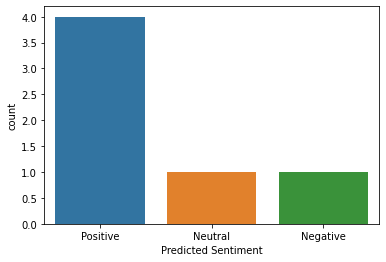

In [56]:
trump['Predicted Sentiment'] = svm.predict(trump['Clean Tweet'])

# Plotting the distribution of sentiments in the covid-19 vaccine tweets dataset
import seaborn as sns
sns.countplot(trump['Predicted Sentiment'])

trump[['tweet', 'screen name', 'Predicted Sentiment']]

### FAMOUS PERSON: JOE BIDEN

##### GETTING SCREEN NAMES OF JOE BIDEN'S FOLLOWERS AND KEEPING ONLY THEIR TWEETS

In [18]:
# Getting screen names of biden's followers

biden_follower_ids = []
for page in tw.Cursor(api.followers_ids, screen_name = 'JoeBiden').pages():
    biden_follower_ids.extend(page)

biden_screen_names = []
for id in biden_follower_ids:
    try:
        user = api.get_user(id)
        biden_screen_names.append(user.screen_name)
    except tw.TweepError as e:
        print(id, str(e))
print("Number of Joe Biden's followers extracted:", len(biden_screen_names))

# Keeping tweets of Joe Biden's followers

def biden_follower(x):
    if x in biden_screen_names:
        return 'Yes'
    else:
        return 'No'

data['Biden Follower?'] = data['screen name'].apply(lambda x: biden_follower(x))
biden = data[data['Biden Follower?'] == 'Yes']
print("Covid-19 Vaccine tweets from Joe Biden's followers are:")
biden.head()

Number of Joe Biden's followers extracted: 12396
Covid-19 Vaccine tweets from Joe Biden's followers are:


,screen name,tweet,Biden Follower?
42142,TelanganaBest,Is 'Centralized' vaccine policy of @ICMRDELHI ...,Yes
47674,TelanganaBest,@dailystarnews @WHO @DrTedros While the world ...,Yes
47856,TelanganaBest,#CovidVaccine from #Hyderabad #COVID19 #coron...,Yes
47875,TelanganaBest,World’s first #CovidVaccine will come from #Hy...,Yes
82876,ItsAbhijit1997,Madhya Pradesh..\n\nTamil nadu cm\nGive free v...,Yes


##### CLEANING AND PREPROCESSING THE TEST DATASET

In [ ]:
biden['Clean Tweet'] = biden['tweet'].apply(lambda x: re.sub('https?:\/\/(www\.)?[-a-zA-Z0–9@:%._\+~#=]{2,256}\.[a-z]{2,6}\b([-a-zA-Z0–9@:%_\+.~#?&//=]*)', '', x))
biden['Clean Tweet'] = biden['Clean Tweet'].apply(lambda x: re.sub('[-a-zA-Z0–9@:%._\+~#=]{2,256}\.[a-z]{2,6}\b([-a-zA-Z0–9@:%_\+.~#?&//=]*)', '', x))
biden['Clean Tweet'] = biden['Clean Tweet'].apply(lambda x: " ".join(x.lower() for x in x.split()))
biden['Clean Tweet'] = biden['Clean Tweet'].str.replace('[^\w\s]','')
biden['Clean Tweet'] = biden['Clean Tweet'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
biden['Clean Tweet'] = biden['Clean Tweet'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

##### USING THE SVM MODEL TO PREDICT SENTIMENTS OF JOE BIDEN'S FOLLOWERS

<ipython-input-22-33d1b2d59136>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  biden['Predicted Sentiment'] = svm.predict(biden['Clean Tweet'])


,tweet,screen name,Predicted Sentiment
42142,Is 'Centralized' vaccine policy of @ICMRDELHI ...,TelanganaBest,Negative
47674,@dailystarnews @WHO @DrTedros While the world ...,TelanganaBest,Neutral
47856,#CovidVaccine from #Hyderabad #COVID19 #coron...,TelanganaBest,Positive
47875,World’s first #CovidVaccine will come from #Hy...,TelanganaBest,Positive
82876,Madhya Pradesh..\n\nTamil nadu cm\nGive free v...,ItsAbhijit1997,Negative


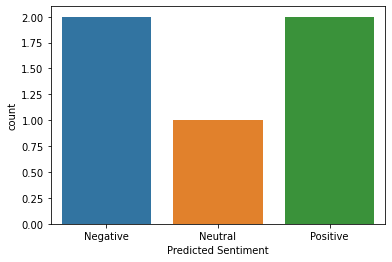

In [22]:
biden['Predicted Sentiment'] = svm.predict(biden['Clean Tweet'])

# Plotting the distribution of sentiments in the covid-19 vaccine tweets dataset
import seaborn as sns
sns.countplot(biden['Predicted Sentiment'])

biden[['tweet', 'screen name', 'Predicted Sentiment']]